In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.preprocessing.sequence import TimeseriesGenerator
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings

warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('C:/Users/shail/Desktop/project/raw data/Device-4.csv')

df.columns = ['SNo','temp','hum','co','no2','pm2_5','pm10','date']
date = df['date']
df = df.drop(["SNo"],axis=1)
df['date'] = pd.to_datetime(df['date'])

In [3]:
df.head()

,temp,hum,co,no2,pm2_5,pm10,date
0,13,52,44,0.88,91,127,2020-01-11 17:07:49
1,13,52,44,0.88,91,127,2020-01-11 17:07:46
2,13,52,44,0.88,91,127,2020-01-11 17:07:39
3,13,52,44,0.90,91,127,2020-01-11 17:07:30
4,13,52,44,0.90,91,127,2020-01-11 17:07:24


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1121348 entries, 0 to 1121347
Data columns (total 7 columns):
 #   Column  Non-Null Count    Dtype         
---  ------  --------------    -----         
 0   temp    1121348 non-null  int64         
 1   hum     1121348 non-null  int64         
 2   co      1121348 non-null  int64         
 3   no2     1121348 non-null  float64       
 4   pm2_5   1121348 non-null  int64         
 5   pm10    1121348 non-null  int64         
 6   date    1121348 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(5)
memory usage: 59.9 MB


In [5]:
df = df[(df['co'] > 0) & (df['no2'] > 0) & (df['pm2_5'] > 0) & (df['pm10'] > 0)]

In [6]:
temp_one_hr = round(df.resample('60min',on='date').temp.mean(),2)
hum_one_hr = round(df.resample('60min',on='date').hum.mean(),2)
co_one_hr = round(df.resample('60min',on='date').co.mean(),2)
no2_one_hr = round(df.resample('60min',on='date').no2.mean(),2)
pm2_5_one_hr = round(df.resample('60min',on='date').pm2_5.mean(),2)
pm10_one_hr = round(df.resample('60min',on='date').pm10.mean(),2)

one_hr_sample = pd.DataFrame({
    "TEMP":temp_one_hr,
    "HUM":hum_one_hr,
    "CO":co_one_hr,
    "NO2":no2_one_hr,
    "PM2.5":pm2_5_one_hr,
    "PM10":pm10_one_hr
})

one_hr_sample

,TEMP,HUM,CO,NO2,PM2.5,PM10
date,,,,,,
2019-09-13 16:00:00,17.69,61.16,6.32,19.40,32.73,45.76
2019-09-13 17:00:00,16.80,67.48,6.43,19.40,38.32,53.31
2019-09-13 18:00:00,17.00,66.82,6.21,19.40,27.65,38.68
2019-09-13 19:00:00,16.40,63.55,5.78,19.39,22.28,31.30
2019-09-13 20:00:00,15.73,66.26,6.06,19.39,22.89,31.97
...,...,...,...,...,...,...
2020-01-11 13:00:00,16.18,44.28,44.00,1.32,78.92,109.69
2020-01-11 14:00:00,20.59,31.49,44.00,1.27,65.24,90.83
2020-01-11 15:00:00,19.94,31.55,44.00,1.20,54.23,75.30


In [7]:
pm = one_hr_sample[['PM2.5']].copy()

In [8]:
pm

,PM2.5
date,
2019-09-13 16:00:00,32.73
2019-09-13 17:00:00,38.32
2019-09-13 18:00:00,27.65
2019-09-13 19:00:00,22.28
2019-09-13 20:00:00,22.89
...,...
2020-01-11 13:00:00,78.92
2020-01-11 14:00:00,65.24
2020-01-11 15:00:00,54.23


In [9]:
df = pm.copy()

In [10]:
df = df[-744:]
df

,PM2.5
date,
2019-12-11 18:00:00,106.17
2019-12-11 19:00:00,104.72
2019-12-11 20:00:00,134.18
2019-12-11 21:00:00,153.91
2019-12-11 22:00:00,158.84
...,...
2020-01-11 13:00:00,78.92
2020-01-11 14:00:00,65.24
2020-01-11 15:00:00,54.23


In [11]:
df.isna().sum()

PM2.5    289
dtype: int64

In [12]:
df = df.interpolate(method ='linear', limit_direction='both')

<AxesSubplot:xlabel='date'>

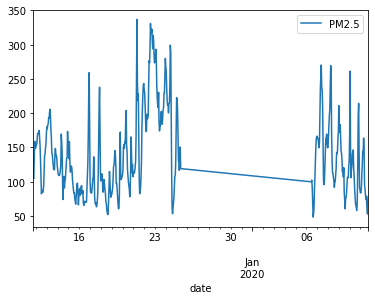

In [13]:
df.plot()

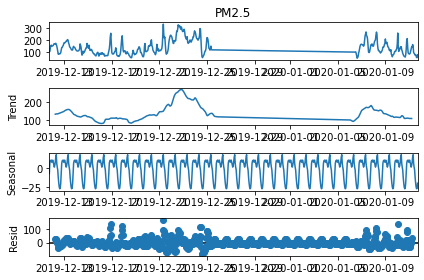

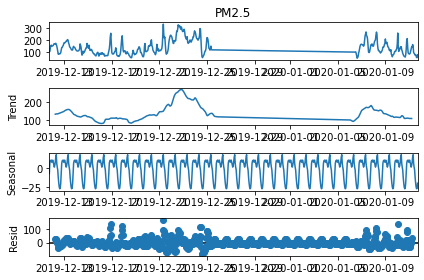

In [14]:
results = seasonal_decompose(df['PM2.5'], freq=24)
results.plot()

In [15]:
len(df)

744

In [16]:
train = df.iloc[:720]
test = df.iloc[720:]

scaler = MinMaxScaler()

In [17]:
df.head(), df.tail()

(                      PM2.5
 date                       
 2019-12-11 18:00:00  106.17
 2019-12-11 19:00:00  104.72
 2019-12-11 20:00:00  134.18
 2019-12-11 21:00:00  153.91
 2019-12-11 22:00:00  158.84,
                      PM2.5
 date                      
 2020-01-11 13:00:00  78.92
 2020-01-11 14:00:00  65.24
 2020-01-11 15:00:00  54.23
 2020-01-11 16:00:00  52.97
 2020-01-11 17:00:00  77.85)

In [18]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

scaled_train[:10]

array([[0.20019436],
       [0.19516174],
       [0.2974108 ],
       [0.36588921],
       [0.38300014],
       [0.34874358],
       [0.35710815],
       [0.36668749],
       [0.37397612],
       [0.4123629 ]])

# Recursive Strategy

In [19]:
n_input = 24
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train,length=n_input,batch_size=1)

generator[0]

(array([[[0.20019436],
         [0.19516174],
         [0.2974108 ],
         [0.36588921],
         [0.38300014],
         [0.34874358],
         [0.35710815],
         [0.36668749],
         [0.37397612],
         [0.4123629 ],
         [0.42478828],
         [0.41864501],
         [0.42051923],
         [0.43860197],
         [0.40097876],
         [0.35901708],
         [0.28522838],
         [0.19248924],
         [0.11824934],
         [0.13723449],
         [0.12765514],
         [0.12480911],
         [0.13539497],
         [0.1610093 ]]]),
 array([[0.24378731]]))

In [20]:
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 200)               161600    
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.fit(generator, epochs=10, verbose=1)

Epoch 1/10
696/696 [==============================] - 128s 27ms/step - loss: 0.0241
Epoch 2/10
696/696 [==============================] - 10s 15ms/step - loss: 0.0098
Epoch 3/10
696/696 [==============================] - 11s 16ms/step - loss: 0.0055
Epoch 4/10
696/696 [==============================] - 12s 18ms/step - loss: 0.0049
Epoch 5/10
696/696 [==============================] - 11s 15ms/step - loss: 0.0049
Epoch 6/10
696/696 [==============================] - 10s 15ms/step - loss: 0.0040
Epoch 7/10
696/696 [==============================] - 12s 17ms/step - loss: 0.0034
Epoch 8/10
696/696 [==============================] - 11s 15ms/step - loss: 0.0040
Epoch 9/10
696/696 [==============================] - 10s 15ms/step - loss: 0.0048
Epoch 10/10
696/696 [==============================] - 12s 18ms/step - loss: 0.0027


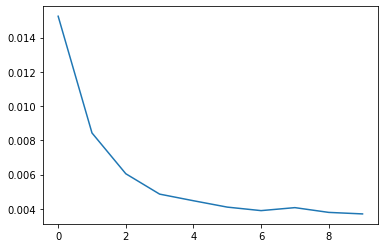

In [22]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

In [23]:
last_train_batch = scaled_train[-n_input:]

last_train_batch = last_train_batch.reshape((1,n_input, n_features))

model.predict(last_train_batch)

array([[0.13421299]], dtype=float32)

In [24]:
scaled_test[0], scaled_test[1]

(array([0.26124531]), array([0.51159239]))

In [25]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    
    test_predictions.append(current_pred)
    
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis=1)
    
test_predictions

[array([0.13421299], dtype=float32),
 array([0.16196424], dtype=float32),
 array([0.18495978], dtype=float32),
 array([0.20359842], dtype=float32),
 array([0.21826765], dtype=float32),
 array([0.22949712], dtype=float32),
 array([0.23793909], dtype=float32),
 array([0.24425894], dtype=float32),
 array([0.24878258], dtype=float32),
 array([0.25199428], dtype=float32),
 array([0.25434762], dtype=float32),
 array([0.25610295], dtype=float32),
 array([0.25745162], dtype=float32),
 array([0.2585274], dtype=float32),
 array([0.25941646], dtype=float32),
 array([0.26015347], dtype=float32),
 array([0.26078612], dtype=float32),
 array([0.26133868], dtype=float32),
 array([0.26183042], dtype=float32),
 array([0.26227006], dtype=float32),
 array([0.2626695], dtype=float32),
 array([0.26303428], dtype=float32),
 array([0.26336604], dtype=float32),
 array([0.26368862], dtype=float32)]

In [26]:
test.head()

,PM2.5
date,
2020-01-10 18:00:00,123.76
2020-01-10 19:00:00,195.89
2020-01-10 20:00:00,214.24
2020-01-10 21:00:00,141.64
2020-01-10 22:00:00,91.89


In [27]:
true_predictions = scaler.inverse_transform(test_predictions)

test['recursive_predict'] = true_predictions

<AxesSubplot:xlabel='date'>

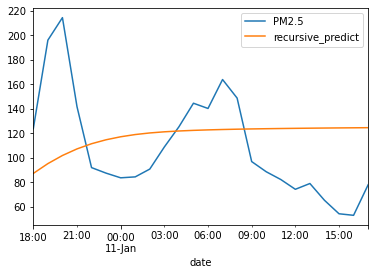

In [28]:
test.plot()

In [29]:
rmse = sqrt(mean_squared_error(test['PM2.5'], test['recursive_predict']))
print(rmse)

48.61768208706246


In [30]:
test

,PM2.5,recursive_predict
date,,
2020-01-10 18:00:00,123.76,87.159445
2020-01-10 19:00:00,195.89,95.155136
2020-01-10 20:00:00,214.24,101.780613
2020-01-10 21:00:00,141.64,107.150778
2020-01-10 22:00:00,91.89,111.377275
2020-01-10 23:00:00,87.37,114.612710
2020-01-11 00:00:00,83.57,117.045010
2020-01-11 01:00:00,84.33,118.865886
2020-01-11 02:00:00,90.69,120.169236


# Direct Startegy

In [31]:
def generate_data(data, n_input, month):
    X, y = [], []
    for i in range(0,len(data)-(n_input+month)):
            X.append(data[i:i+n_input])
            y.append(data[i+n_input+(month-1)])
    return np.array(X), np.array(y)

In [32]:
def model_predict(m_no, train_data, n_input, n_features):
    
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    X, y = generate_data(train_data, n_input, m_no)
    
    #print("MODEL : ", m_no)
    #print(X[0], y[0])
    
    model.fit(X, y, epochs=3, verbose=0)
    
    tX = train_data[-n_input:]
    
    tX = tX.reshape((1, n_input, n_features))
    
    res = model.predict(tX)
    
    return res[0]

In [33]:
n_input = 24
n_features = 1
test_predictions = []

for i in range(len(scaled_test)):
    test_predictions.append(model_predict(i+1,scaled_train,n_input, n_features))
    
test_predictions

[array([0.18197869], dtype=float32),
 array([0.1697245], dtype=float32),
 array([0.16731323], dtype=float32),
 array([0.18810941], dtype=float32),
 array([0.19145647], dtype=float32),
 array([0.19269995], dtype=float32),
 array([0.20470554], dtype=float32),
 array([0.19127917], dtype=float32),
 array([0.21407004], dtype=float32),
 array([0.20756488], dtype=float32),
 array([0.17577054], dtype=float32),
 array([0.24907935], dtype=float32),
 array([0.23075554], dtype=float32),
 array([0.19275157], dtype=float32),
 array([0.18620087], dtype=float32),
 array([0.20318139], dtype=float32),
 array([0.22888625], dtype=float32),
 array([0.22183251], dtype=float32),
 array([0.1870475], dtype=float32),
 array([0.21167956], dtype=float32),
 array([0.18092549], dtype=float32),
 array([0.2085982], dtype=float32),
 array([0.16328256], dtype=float32),
 array([0.18468149], dtype=float32)]

In [34]:
true_predictions = scaler.inverse_transform(test_predictions)

test['direct_predict'] = true_predictions

<AxesSubplot:xlabel='date'>

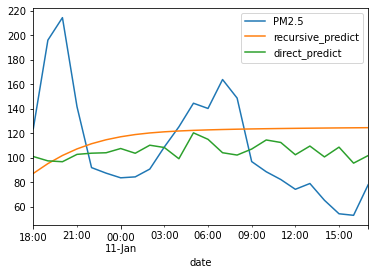

In [35]:
test.plot()

In [36]:
rmse = sqrt(mean_squared_error(test['PM2.5'], test['direct_predict']))
print(rmse)

43.263251649901285


In [37]:
test

,PM2.5,recursive_predict,direct_predict
date,,,
2020-01-10 18:00:00,123.76,87.159445,100.921699
2020-01-10 19:00:00,195.89,95.155136,97.391021
2020-01-10 20:00:00,214.24,101.780613,96.696289
2020-01-10 21:00:00,141.64,107.150778,102.688084
2020-01-10 22:00:00,91.89,111.377275,103.652437
2020-01-10 23:00:00,87.37,114.612710,104.010711
2020-01-11 00:00:00,83.57,117.045010,107.469759
2020-01-11 01:00:00,84.33,118.865886,103.601355
2020-01-11 02:00:00,90.69,120.169236,110.167859


# Direct Recursive Startegy

In [38]:
def generate_data(data, n_input, month):
    X, y = [], []
    for i in range(0,len(data)-(n_input+month)):
            X.append(data[i:i+n_input+(month-1)])
            y.append(data[i+n_input+(month-1)])
    return np.array(X), np.array(y)

In [39]:
def model_predict(m_no, train_data, n_input, n_features):
    
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_input+(m_no - 1), n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    X, y = generate_data(train_data, n_input, m_no)
    #print(y.dtype)
    
    #print("Model No.  - ", m_no)
    #print(X[0], y[0])
    #print("SHAPE XY : ", X.shape, y.shape)
    
    model.fit(X, y, epochs=3, verbose=0)
    
    tX = train_data[-n_input:]
    tP = np.array(test_predictions)
    
    tX = np.concatenate((tX, tP), axis=None)
    
    #print("TYPE : ", type(tX), type(tP))
    
    #print("TX : ", tX)
        
    #print("SHAPE : " , tX.shape)
    
    tX = tX.reshape((1, tX.shape[0], n_features))
    
    res = model.predict(tX)
    
    return res[0]

In [40]:
n_input = 24
n_features = 1
test_predictions = []

for i in range(len(scaled_test)):
    pred = model_predict(i+1,scaled_train,n_input, n_features)
    test_predictions.append(pred)
    
test_predictions

[array([0.14965446], dtype=float32),
 array([0.17262103], dtype=float32),
 array([0.18598668], dtype=float32),
 array([0.18043476], dtype=float32),
 array([0.17936772], dtype=float32),
 array([0.23576961], dtype=float32),
 array([0.20628537], dtype=float32),
 array([0.18407686], dtype=float32),
 array([0.20061287], dtype=float32),
 array([0.21108742], dtype=float32),
 array([0.22552978], dtype=float32),
 array([0.21817651], dtype=float32),
 array([0.18892027], dtype=float32),
 array([0.1993644], dtype=float32),
 array([0.19852284], dtype=float32),
 array([0.21230859], dtype=float32),
 array([0.20504583], dtype=float32),
 array([0.2162423], dtype=float32),
 array([0.20489417], dtype=float32),
 array([0.19067752], dtype=float32),
 array([0.1873977], dtype=float32),
 array([0.21766241], dtype=float32),
 array([0.20399742], dtype=float32),
 array([0.19722532], dtype=float32)]

In [41]:
true_predictions = scaler.inverse_transform(test_predictions)

test['direct_recursive_predict'] = true_predictions

<AxesSubplot:xlabel='date'>

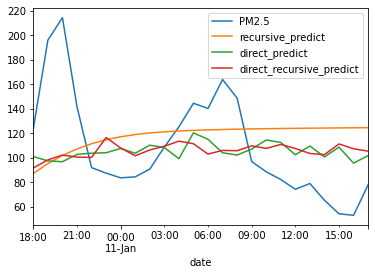

In [42]:
test.plot()

In [43]:
rmse = sqrt(mean_squared_error(test['PM2.5'], test['direct_recursive_predict']))
print(rmse)

43.820622047699956


In [44]:
test

,PM2.5,recursive_predict,direct_predict,direct_recursive_predict
date,,,,
2020-01-10 18:00:00,123.76,87.159445,100.921699,91.608444
2020-01-10 19:00:00,195.89,95.155136,97.391021,98.225570
2020-01-10 20:00:00,214.24,101.780613,96.696289,102.076483
2020-01-10 21:00:00,141.64,107.150778,102.688084,100.476864
2020-01-10 22:00:00,91.89,111.377275,103.652437,100.169428
2020-01-10 23:00:00,87.37,114.612710,104.010711,116.419941
2020-01-11 00:00:00,83.57,117.045010,107.469759,107.924941
2020-01-11 01:00:00,84.33,118.865886,103.601355,101.526225
2020-01-11 02:00:00,90.69,120.169236,110.167859,106.290581


# MIMO

In [45]:
def generate_data(data, n_input, n_output):
    X, y = [], []
    for i in range(0,len(data)-(n_input+n_output)):
            X.append(data[i:(i+n_input)])
            y.append(data[i+n_input: i+n_input+n_output])
    return np.array(X), np.array(y)

In [46]:
n_input = 24
n_features = 1
n_output = len(scaled_test)

X, y = generate_data(scaled_train, n_input, n_output)

In [47]:
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(n_output))
model.compile(optimizer='adam', loss='mse')

In [48]:
model.fit(X, y, epochs=3, verbose=0)

In [49]:
model.summary()

Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_49 (LSTM)               (None, 200)               161600    
_________________________________________________________________
dense_49 (Dense)             (None, 24)                4824      
Total params: 166,424
Trainable params: 166,424
Non-trainable params: 0
_________________________________________________________________


In [50]:
tX = scaled_train[-n_input:]
tX = tX.reshape((1, tX.shape[0], n_features))

res = model.predict(tX)

res = res.reshape((res.shape[1],1))

In [51]:
res.shape

(24, 1)

In [52]:
true_predictions = scaler.inverse_transform(res)

test['MIMO_predict'] = true_predictions

In [53]:
test

,PM2.5,recursive_predict,direct_predict,direct_recursive_predict,MIMO_predict
date,,,,,
2020-01-10 18:00:00,123.76,87.159445,100.921699,91.608444,116.700897
2020-01-10 19:00:00,195.89,95.155136,97.391021,98.225570,113.761826
2020-01-10 20:00:00,214.24,101.780613,96.696289,102.076483,118.658447
2020-01-10 21:00:00,141.64,107.150778,102.688084,100.476864,117.103912
2020-01-10 22:00:00,91.89,111.377275,103.652437,100.169428,116.582359
2020-01-10 23:00:00,87.37,114.612710,104.010711,116.419941,112.936287
2020-01-11 00:00:00,83.57,117.045010,107.469759,107.924941,116.396339
2020-01-11 01:00:00,84.33,118.865886,103.601355,101.526225,112.612396
2020-01-11 02:00:00,90.69,120.169236,110.167859,106.290581,113.624962


<AxesSubplot:xlabel='date'>

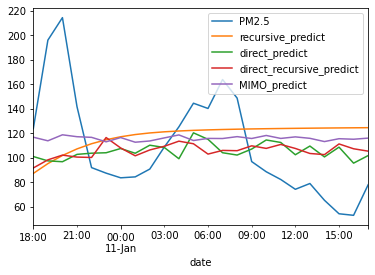

In [54]:
test.plot()

In [55]:
rmse = sqrt(mean_squared_error(test['PM2.5'], test['MIMO_predict']))
print(rmse)

41.84113410142793


# Direct MIMO

In [56]:
def generate_data(data, n_input, q_no, n_output):
    X, y = [], []
    for i in range(0,len(data)-(n_input + ((q_no-1)*n_output) + n_output)):
            X.append(data[i:(i+n_input)])
            y.append(data[i+n_input+((q_no-1)*n_output): i+n_input+((q_no-1)*n_output) + n_output])
    return np.array(X), np.array(y)

In [57]:
def model_predict(train_data, n_input, n_features, q_no, n_output):
    
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
    model.add(Dense(n_output))
    model.compile(optimizer='adam', loss='mse')
    
    X, y = generate_data(train_data, n_input, q_no, n_output)
    
    model.fit(X, y, epochs=3, verbose=0)
    
    tX = train_data[-n_input:]
    
    tX = tX.reshape((1, n_input, n_features))
    
    res = model.predict(tX)
    
    return res

In [58]:
n_input = 12
n_features = 1
test_predictions = []

n_output = 6

q = int(len(scaled_test)/n_output)

for i in range(q):
    pred = model_predict(scaled_train,n_input, n_features, i+1, n_output)
    test_predictions.append(pred)

test_predictions

[array([[0.197003  , 0.20268299, 0.20694391, 0.20239373, 0.19905794,
         0.20408729]], dtype=float32),
 array([[0.19882151, 0.20112637, 0.19389701, 0.20467241, 0.20888133,
         0.19210143]], dtype=float32),
 array([[0.20722164, 0.20810717, 0.2106239 , 0.20474324, 0.21190552,
         0.20871043]], dtype=float32),
 array([[0.22552577, 0.22424158, 0.2219946 , 0.22264098, 0.21646704,
         0.22113968]], dtype=float32)]

In [59]:
res = []

for i in test_predictions:
    for j in i:
        for k in j:
            res.append(k)

In [60]:
res = np.array(res[:len(scaled_test)])
res = res.reshape((res.shape[0],1))
res.shape

(24, 1)

In [61]:
true_predictions = scaler.inverse_transform(res)

test['Direct_MIMO_predict'] = true_predictions

In [62]:
test

,PM2.5,recursive_predict,direct_predict,direct_recursive_predict,MIMO_predict,Direct_MIMO_predict
date,,,,,,
2020-01-10 18:00:00,123.76,87.159445,100.921699,91.608444,116.700897,105.250504
2020-01-10 19:00:00,195.89,95.155136,97.391021,98.225570,113.761826,106.887024
2020-01-10 20:00:00,214.24,101.780613,96.696289,102.076483,118.658447,108.114677
2020-01-10 21:00:00,141.64,107.150778,102.688084,100.476864,117.103912,106.803680
2020-01-10 22:00:00,91.89,111.377275,103.652437,100.169428,116.582359,105.842567
2020-01-10 23:00:00,87.37,114.612710,104.010711,116.419941,112.936287,107.291626
2020-01-11 00:00:00,83.57,117.045010,107.469759,107.924941,116.396339,105.774452
2020-01-11 01:00:00,84.33,118.865886,103.601355,101.526225,112.612396,106.438522
2020-01-11 02:00:00,90.69,120.169236,110.167859,106.290581,113.624962,104.355598


<AxesSubplot:xlabel='date'>

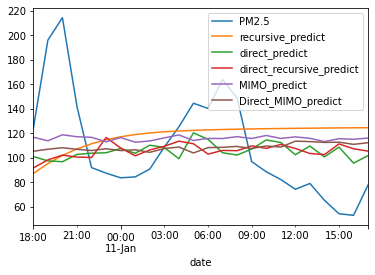

In [63]:
test.plot()

In [64]:
rmse = sqrt(mean_squared_error(test['PM2.5'], test['Direct_MIMO_predict']))
print(rmse)

42.91038776517978


In [65]:
rec_err = abs(test['PM2.5'] - test['recursive_predict'])
dir_err = abs(test['PM2.5'] - test['direct_predict'])
dir_rec_err = abs(test['PM2.5'] - test['direct_recursive_predict'])
mimo_err = abs(test['PM2.5'] - test['MIMO_predict'])
dir_mimo_err = abs(test['PM2.5'] - test['Direct_MIMO_predict'])

In [66]:
errors = pd.DataFrame({
    'Recursive':rec_err,
    'Direct':dir_err,
    'Direct Recursive':dir_rec_err,
    'MIMO':mimo_err,
    'Direct MIMO':dir_mimo_err
})

In [67]:
errors

,Recursive,Direct,Direct Recursive,MIMO,Direct MIMO
date,,,,,
2020-01-10 18:00:00,36.600555,22.838301,32.151556,7.059103,18.509496
2020-01-10 19:00:00,100.734864,98.498979,97.664430,82.128174,89.002976
2020-01-10 20:00:00,112.459387,117.543711,112.163517,95.581553,106.125323
2020-01-10 21:00:00,34.489222,38.951916,41.163136,24.536088,34.836320
2020-01-10 22:00:00,19.487275,11.762437,8.279428,24.692359,13.952567
2020-01-10 23:00:00,27.242710,16.640711,29.049941,25.566287,19.921626
2020-01-11 00:00:00,33.475010,23.899759,24.354941,32.826339,22.204452
2020-01-11 01:00:00,34.535886,19.271355,17.196225,28.282396,22.108522
2020-01-11 02:00:00,29.479236,19.477859,15.600581,22.934962,13.665598


<AxesSubplot:xlabel='date'>

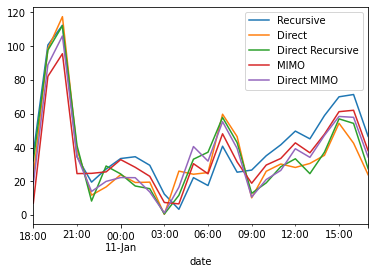

In [68]:
errors.plot()

In [69]:
len(scaled_test)

24